# PROJECT ->  TIME SERIES 

`USING DIFFERENT TIME SERIES TO PREDICT PM VALUE OF AIR IN NAIROBI LOCATION OF AFRICA`

## LINEAR MODEL WITH TIME SERIES DATA

- GOALS
    -  Prepare Nairobi data.
    -  Cretae linear model to predict PM2.5 readings


- Workflow Pipeline

    - Step1 (`Prepare Data`)
        
        - Import Localize timezone
        
        - Explore Rolling average, Lag, autocorrelation
        
        - Split (train - test split)

    - Step2 (`Build Model`)
        
        - Create Baseline

        - Iterate

        - Evaluate

    - Step3 (`Communicate Results`)
    
        - Time series plot with plotly express
    


## Libraries

In [3]:


import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

## Import Data

In [10]:
# Importing data and setting up timestamp as index  
nairobi = pd.read_csv("data//Nairobi.csv").set_index("timestamp")
nairobi.head()

,P2
timestamp,
2018-09-01 00:00:02.472,34.43
2018-09-01 00:05:03.941,30.53
2018-09-01 00:10:04.374,22.80
2018-09-01 00:15:04.245,13.30
2018-09-01 00:20:04.869,16.57


## Preparing Data

In [85]:
# Checking for index values
nairobi.index[:5]  # its is showing datetime index as object type ,so lets convert it..

Index(['2018-09-01 00:00:02.472', '2018-09-01 00:05:03.941',
       '2018-09-01 00:10:04.374', '2018-09-01 00:15:04.245',
       '2018-09-01 00:20:04.869'],
      dtype='object', name='timestamp')

In [86]:
# Creating wrangle function

def wrangle(data):
    # Converting index object type to datetime type 
    data.index = pd.to_datetime(data.index)
    
    # localizing timezone to its original localtion ("Africa/Nairobi")
    data.index = data.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remvoing Outliers
    data = data[data["P2"]< 500]

    # Resampling to hour window and impute missing using forward fill
    data = data["P2"].resample("1H").mean().fillna(method = "ffill").to_frame()

    # Creating Lag feature
    data["P2.L1"] = data["P2"].shift(1)
    
    #Dropping NAN  rows 
    data.dropna(inplace =True)
    return data


nairobi = wrangle(nairobi)
    

In [70]:
# We convert it to its local time zone.. 
nairobi.index[:5]

DatetimeIndex(['2018-09-01 03:00:00+03:00', '2018-09-01 04:00:00+03:00',
               '2018-09-01 05:00:00+03:00', '2018-09-01 06:00:00+03:00',
               '2018-09-01 07:00:00+03:00'],
              dtype='datetime64[ns, Africa/Nairobi]', name='timestamp', freq='H')

In [71]:
print(nairobi.head())
print(nairobi.shape)

                                  P2
timestamp                           
2018-09-01 03:00:00+03:00  17.541667
2018-09-01 04:00:00+03:00  15.800000
2018-09-01 05:00:00+03:00  11.420000
2018-09-01 06:00:00+03:00  11.614167
2018-09-01 07:00:00+03:00  17.665000
(2928, 1)


##  Exploring Distribution of P value

<AxesSubplot: title={'center': 'Distribution of PM2.5 Readings'}>

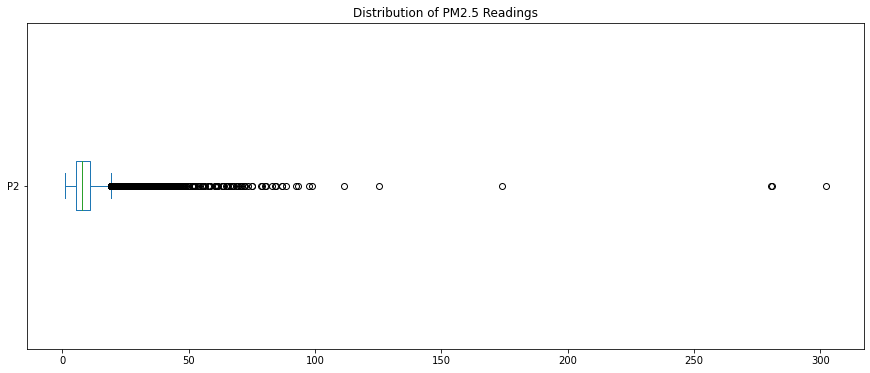

In [46]:
# Canvas parameter setup
fig, ax = plt.subplots(figsize=(15, 6))

# Creating boxplot for p

nairobi["P2"].plot(kind="box", vert =False, title = "Distribution of PM2.5 Readings" , ax=ax)

#### Conclusion of Boxplot 

- Outliers in data as it is not possible for PM2.5 value to be on 700 range , We have to update our wrangle function with respect to some reference.

- This is given Envoirmnetal Protection Agency of US

- According to refernce

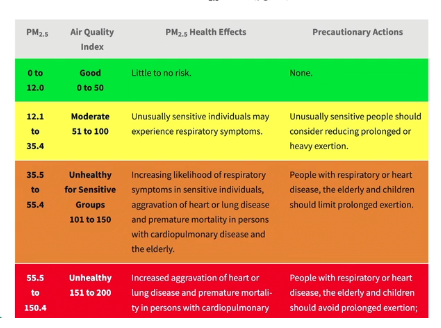
    
    - Range of 0 to 12 seems Good.

    - Range of 12 to 35.4 seems Moderate.

    - Range of 35.4 to 55.4 seems Unhealthy (For Sensitive Beings).

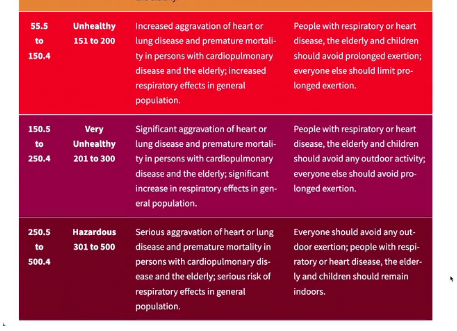

    - Range of 55.4 to 150.4 seems Unhealthy for all.

    - Range of 150.5 to 250.4 seems really Bad. 

    - And at last , Range of 250.5 to 500.4 is Hazardeous.



> So after concerning this , we update wrangle so that values above 500 will removed and not be in our resultant data ..
        
        `nairobi[nairobi["P2"]< 500]`

Result of wrangle -> there is only 1 outlier which get removed in new data

## Time Series Plot

<AxesSubplot: title={'center': 'PM2.5 Time Series'}, xlabel='Time', ylabel='PM2.5'>

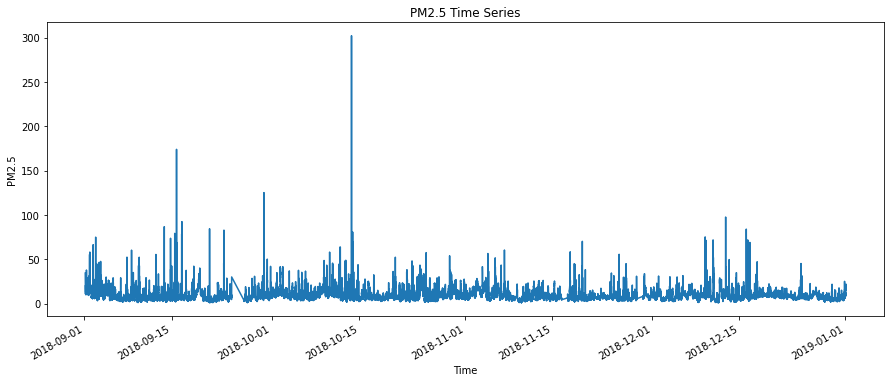

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))
nairobi["P2"].plot(xlabel= "Time",ylabel= "PM2.5", title= "PM2.5 Time Series",ax=ax)

### Plot conclusion 
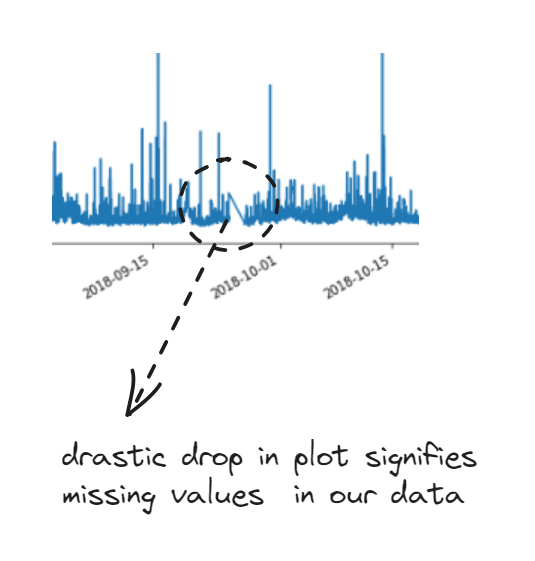

## Just Think...

- Whenever we want to build a model, we always have in mind what we have to predict.
        
        - In my project, i am predicting PM2.5 values.


- There is another thing we have to be in our mind in case of time series is ,In what interval we want to predict our values 
        
        - It either be every second, every minute , every hour , or every day.


-  So as final, I decided to do hourly prediction for that, I had to adjust my interval reading of data as per my requirment (`Hourly prediction`)

In [49]:
nairobi.head()

,P2
timestamp,
2018-09-01 03:00:02.472000+03:00,34.43
2018-09-01 03:05:03.941000+03:00,30.53
2018-09-01 03:10:04.374000+03:00,22.80
2018-09-01 03:15:04.245000+03:00,13.30
2018-09-01 03:20:04.869000+03:00,16.57


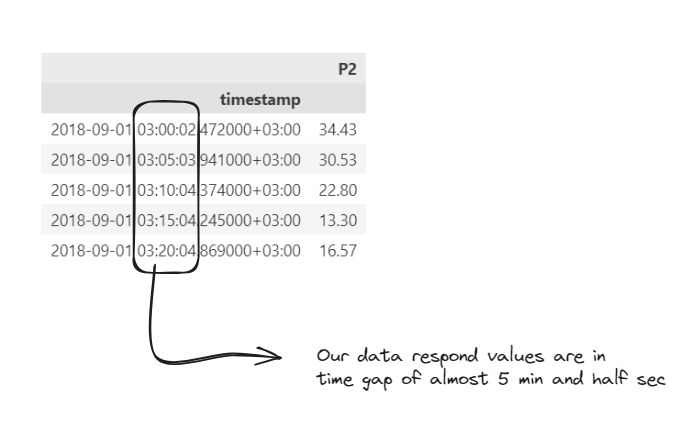


- So for making hour predictions, We do resampling using `resample` and hour as its argument


In [66]:
nairobi["P2"].resample("1H") 
# It is giving ilterator because we are dealing with time series and under this interval of hour it conatin lot of values ....

# Lets retrive average value
nairobi["P2"].resample("1H").mean()

# check whether our interval contain missing values as it has adverse affect in our model
nairobi["P2"].resample("1H").mean().isnull().sum()


<AxesSubplot: title={'center': 'PM2.5 Time Series'}, xlabel='timestamp', ylabel='PM2.5'>

- Data has 102 missing values, lets impute them.

- I am using a technique called `Forward Fill`


## Explaining Forward Fill Technique for missing imputation.

- Also known as forward filling or last observation carried forward (LOCF).

- Overview of Technique

> In the forward fill technique, missing values are replaced with the last known or observed value. This approach assumes that the missing values should be filled with the most recent value available, implying that the pattern or trend observed in the past continues into the future.

- Visualizing Technique

Lets suppose we have a data which have missing values in a time gap represented below 


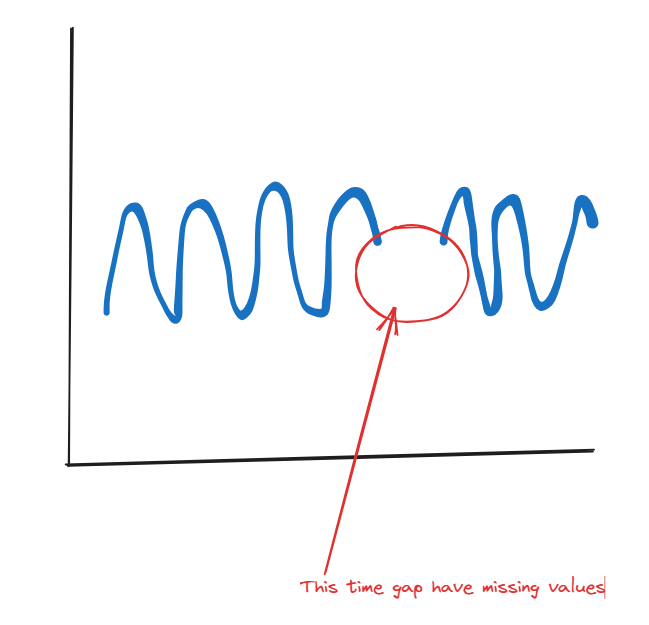 


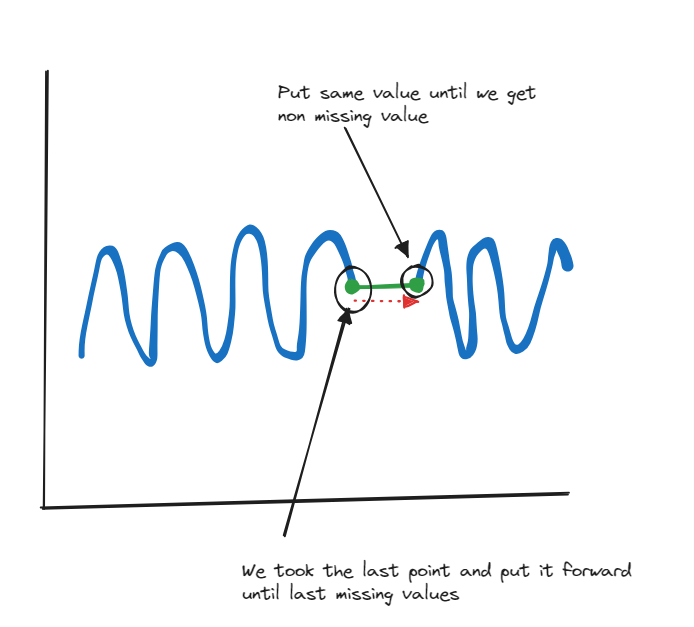



- When to use this Technique??

    - This Technique can be useful in scenarios where the missing values occur sporadically or when the missing data points are expected to follow a similar pattern as the existing data

In [64]:
# Filling null values using forward fill
nairobi["P2"].resample("1H").mean().fillna(method = "ffill")

# checking for null values now 
nairobi["P2"].resample("1H").mean().fillna(method = "ffill").isnull().sum()

# So  lets update our wrange function with nairobi["P2"].resample("1H").mean().fillna(method = "ffill")


0

## Affects after resampling 

<AxesSubplot: title={'center': 'Distribution of PM2.5 Readings'}>

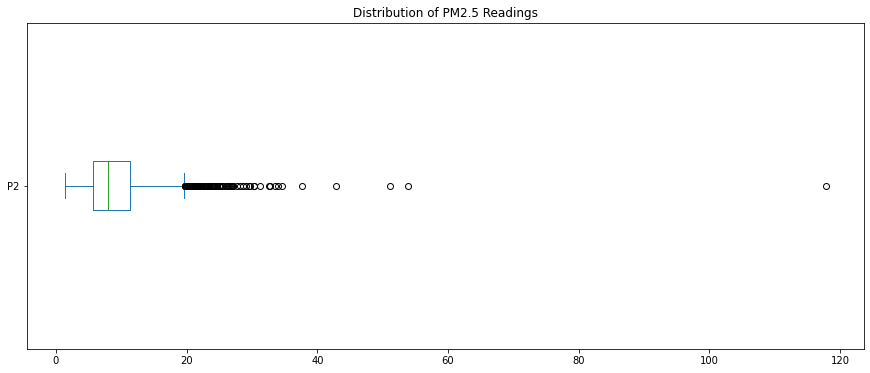

In [72]:
# New sampled data boxplot 

# Canvas parameter setup
fig, ax = plt.subplots(figsize=(15, 6))

# Creating boxplot for p
nairobi["P2"].plot(kind="box", vert =False, title = "Distribution of PM2.5 Readings" , ax=ax)

<AxesSubplot: title={'center': 'PM2.5 Time Series'}, xlabel='Time', ylabel='PM2.5'>

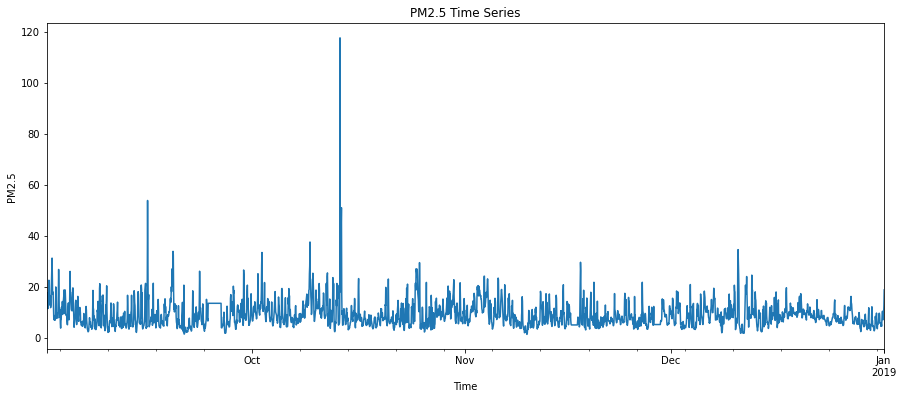

In [73]:
fig, ax = plt.subplots(figsize=(15, 6))
nairobi["P2"].plot(xlabel= "Time",ylabel= "PM2.5", title= "PM2.5 Time Series",ax=ax)

### Conclusion of plots

- Values of boxplot range reduced.

- Forward fill apllied and worked as same.

## ROLLING AVERAGE 

    - A way to smooth out time series data to understand general trend.


As from our new plot we had identify that there are lot of peaks and valleys.

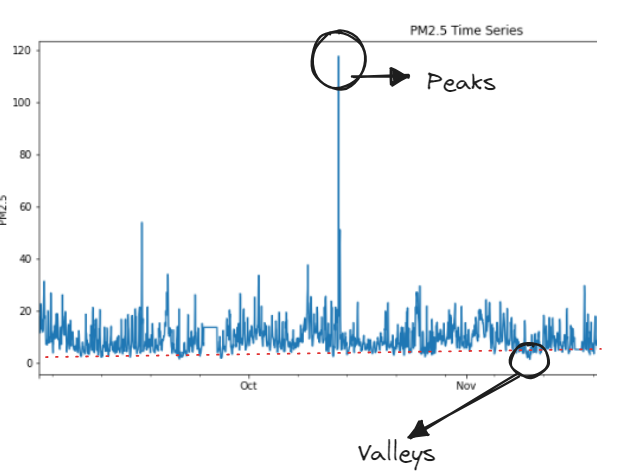

- Due to these peaks and valleys jumping a lot (moving up and down ), its get difficult to analyze pattern (whetherincreasing or decreasing).

- To Overcome these , we have Rolling average which also called Rolling window average


### Rolling Window Average Explained !!!

Step1 - Creating window of fix time.

Step2 - Taking average of that and plot it in graph.

Step3 - Move window for next time gap.

Step4 - follow Step2 and Step3 unitl it end.

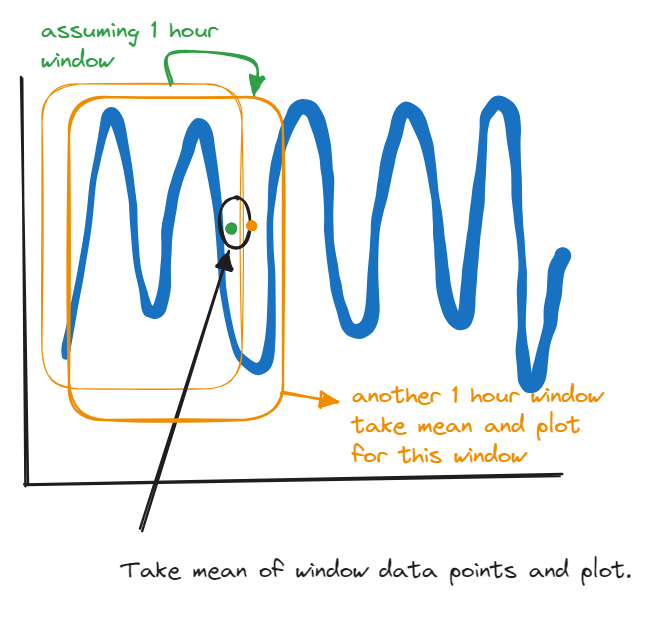


- Finally It looks like...

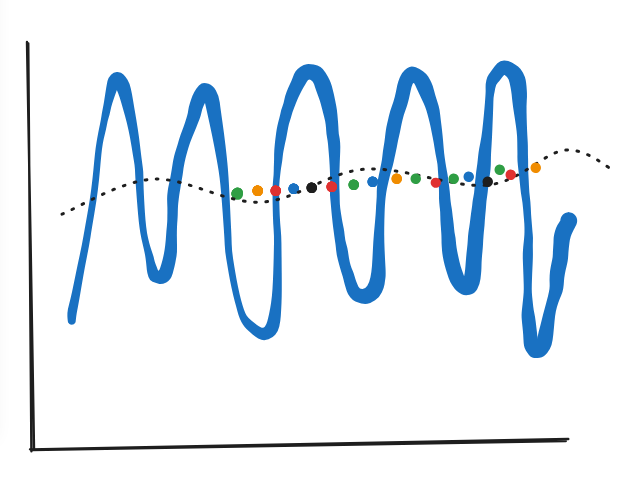


In [74]:
# Computing rolling average of Week 
nairobi["P2"].rolling(168).mean().head()

# Why 168 ? right...

# As we are hourly plotting , therfore in a week 24 * 7  = 168... 


# Lets see count of missing values
nairobi["P2"].rolling(168).mean().isnull().sum()

# Why 1 Less than 168 window ? right

# It's telling that there is nothing in first 168 values as there is no complete window  

167

<AxesSubplot: title={'center': 'Weekly Rolling Average'}, xlabel='Hours', ylabel='PM2.5'>

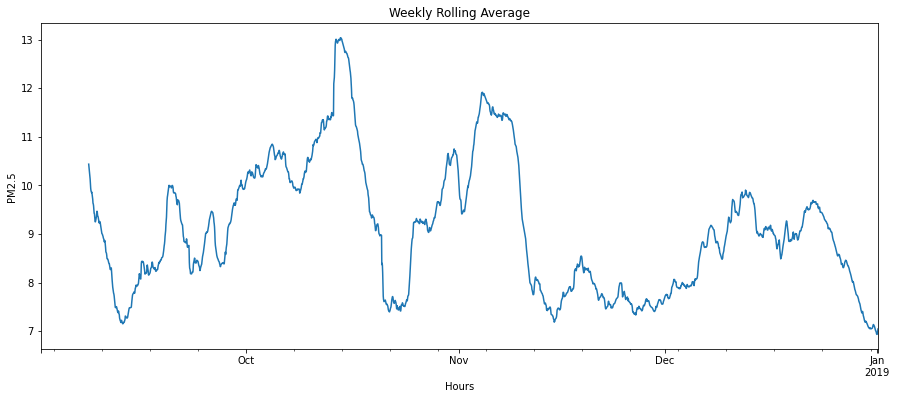

In [77]:
# Lets plot it 

fig, ax = plt.subplots(figsize=(15, 6))
nairobi["P2"].rolling(168).mean().plot(xlabel = "Hours",ylabel = "PM2.5",ax=ax, title = "Weekly Rolling Average")


- NOTE

    - Our Y-axis range gets reduced and plot becomes more smoother than previous one.

    - Also we found that there is no specific trend identified in plot.  

## Custom Feature Creation

- Data have :
    
    - timestamp(index)
    
    - PM Value (target)



- Feature 
    - So for making feature for model, We shift data and create a lag named (P2.L1).
    
    - L1 shows we shift the data by 1.

In [80]:
# Without feature
nairobi["P2"].head()

timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

In [83]:
nairobi["P2.L1"] = nairobi["P2"].shift(1)
nairobi["P2.L1"].head()

# Dropping NA values 
nairobi["P2.L1"].dropna().head()

# So now we update our wrangle function...

timestamp
2018-09-01 04:00:00+03:00    17.541667
2018-09-01 05:00:00+03:00    15.800000
2018-09-01 06:00:00+03:00    11.420000
2018-09-01 07:00:00+03:00    11.614167
2018-09-01 08:00:00+03:00    17.665000
Freq: H, Name: P2.L1, dtype: float64

### Understanding Relationship Betweeen Feature and Target

- Feature `PM2.5`

- Target `Lag`


>  As we know that we have only 2 features in which 
    
    - PM2.5 show value over time.

    - PM2.5.L1 shows value of of PM2.5 1 hour ago.


- So now it's time to do autocorrelation

In [87]:
# Correlation beween features

nairobi.corr()

,P2,P2.L1
P2,1.000000,0.650679
P2.L1,0.650679,1.000000


Text(0.5, 1.0, 'PM2.5 Autocorrelation')

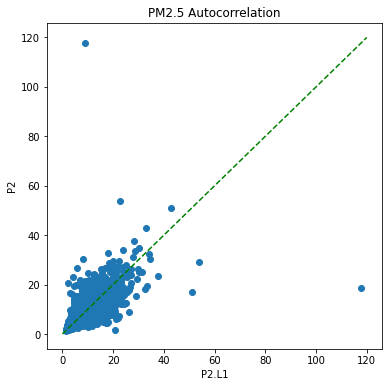

In [92]:
# Scatter plot 
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x =nairobi["P2.L1"], y=nairobi["P2"])
ax.plot([0,120],[0,120], linestyle ="--" ,color="green" )
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Autocorrelation")

# TRAIN - TEST SPLIT

In [94]:
# Define target
target = "P2"

# Target Vector
y = nairobi[target]

# Feature Matrix
X = nairobi.drop(columns = target)

In [95]:
X.head()

,P2.L1
timestamp,
2018-09-01 04:00:00+03:00,17.541667
2018-09-01 05:00:00+03:00,15.800000
2018-09-01 06:00:00+03:00,11.420000
2018-09-01 07:00:00+03:00,11.614167
2018-09-01 08:00:00+03:00,17.665000


In [96]:
y.head()

timestamp
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
2018-09-01 08:00:00+03:00    21.016667
Freq: H, Name: P2, dtype: float64

### Splitting Technique

- Splitting of data in time series case is something special which we called as `Cutoff`

- In time series you cannot randomly split data into groups, as it leads to leakage in model. The thing we have to keep in mind is that our train must come before our split

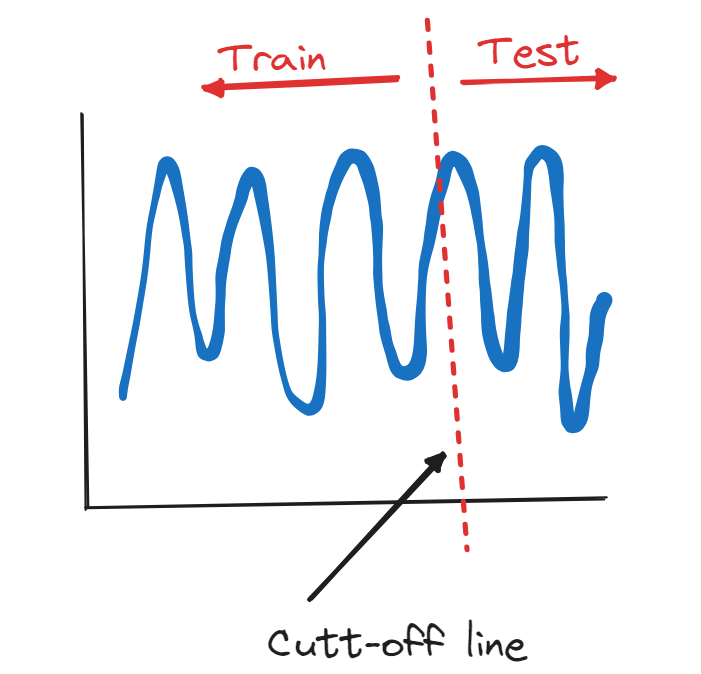

In [115]:
# Splitting in 80-20 %


# check for length
print("train set contain : ",len(nairobi) * 0.8)
print("test set contain : ",len(nairobi)*0.2)

# Cuttoff 
Cutoff = int(len(nairobi) * 0.8)

train set contain :  2341.6
test set contain :  585.4


In [117]:
len(X.iloc[:Cutoff])


2341

In [119]:
X_train, y_train = X.iloc[:Cutoff], y.iloc[:Cutoff]
X_test, y_test = X.iloc[Cutoff:], y.iloc[Cutoff:]

In [120]:
# Creating Baseline 

y_mean =y_train.mean()
y_pred_baseline = [y_mean] * len(y_train) 
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.27
Baseline MAE: 3.89


In [121]:
# Fit model

model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [122]:
# Calculating MAE for train and test set

training_mae = mean_absolute_error(y_train, model.predict(X_train))

test_mae =mean_absolute_error(y_test,model.predict(X_test))

print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.46
Test MAE: 1.8


In [123]:
# Formula for model

intercept = round(model.intercept_,2)
coefficient = round(model.coef_[0],2)

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 3.36 + (0.64 * P2.L1)


In [124]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred":model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-12-07 17:00:00+03:00,7.070000,8.478927
2018-12-07 18:00:00+03:00,8.968333,7.865485
2018-12-07 19:00:00+03:00,11.630833,9.076421
2018-12-07 20:00:00+03:00,11.525833,10.774814
2018-12-07 21:00:00+03:00,9.533333,10.707836


In [125]:
# Create Line plot
fig, ax = plt.subplots(figsize=(15, 6))
fig = px.line(df_pred_test, labels={"value":"P2"})
fig.show()

# USING AR (AUTO REGRESSION) MODEL FOR PREDICTION

    - These models work with Series object so we have to modify our wrangle function

In [22]:
# Some libraries 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [11]:
# Modifying wrangle function

def wrangle(data):

    # Converting index object type to datetime type 
    data.index = pd.to_datetime(data.index)
    
    # localizing timezone to its original localtion ("Africa/Nairobi")
    data.index = data.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remvoing Outliers
    data = data[data["P2"]< 500]

    # Resampling to hour window and impute missing using forward fill and also removing to_frame()
    data = data["P2"].resample("1H").mean().fillna(method = "ffill")

    return data

In [12]:
Nairobi_series = wrangle(nairobi)
Nairobi_series.head()

timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

## Concept of ACF plots!!!

- In Linear model that we just done before , we use a feature called lag which helps model to understand what's the value 1 hour before and help it in forecasting. We done this because we get correlation between target and lag feature ....


> Why will we just let ourself under a limit to just shift 1 hour ago what if we are able to get the correlatin n (where n = 1,2,3,4 ,.....) hours before. I think it great to have to find historical pattern and to strength our model ... why not 😁😁😁😁


- To get how any lags are useful for our model to have great predictive power is given by `ACF Plot and PACF plot` is helpful.


In [17]:
# Let undersatnd the correlation between lags 

# Correlation between now and 1 hour ago.
print(Nairobi_series.corr(Nairobi_series.shift(1)))

# Correlation between now and 2 hour ago.
print(Nairobi_series.corr(Nairobi_series.shift(2)))

# Correlation between now and 3 hour ago.
print(Nairobi_series.corr(Nairobi_series.shift(3)))

0.6506785333937846
0.44267376546649534
0.3127208047457686


#### Plotting ACF plot

Text(0.5, 1.0, 'ACF Plot')

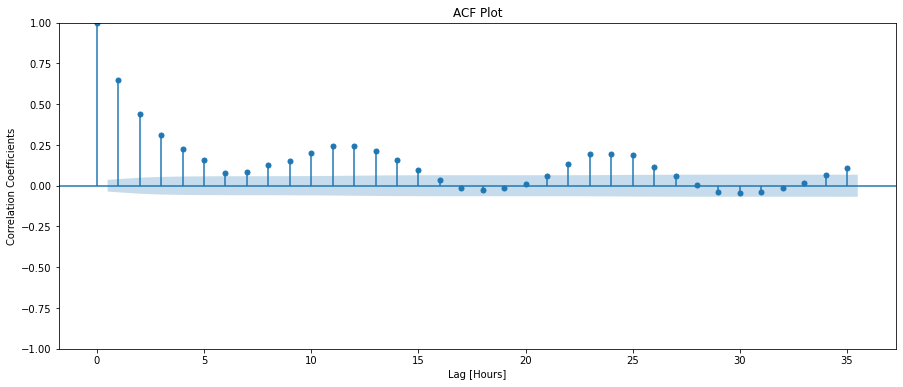

In [24]:
# Setting plot size. 
fig, ax = plt.subplots(figsize = (15,6))

# Statmodel function for pplotting acf.
plot_acf(Nairobi_series, ax=ax)

# x-axis labeling
plt.xlabel("Lag [Hours]")

# y-axis labelling
plt.ylabel("Correlation Coefficients")


# Title of plot
plt.title("ACF Plot")

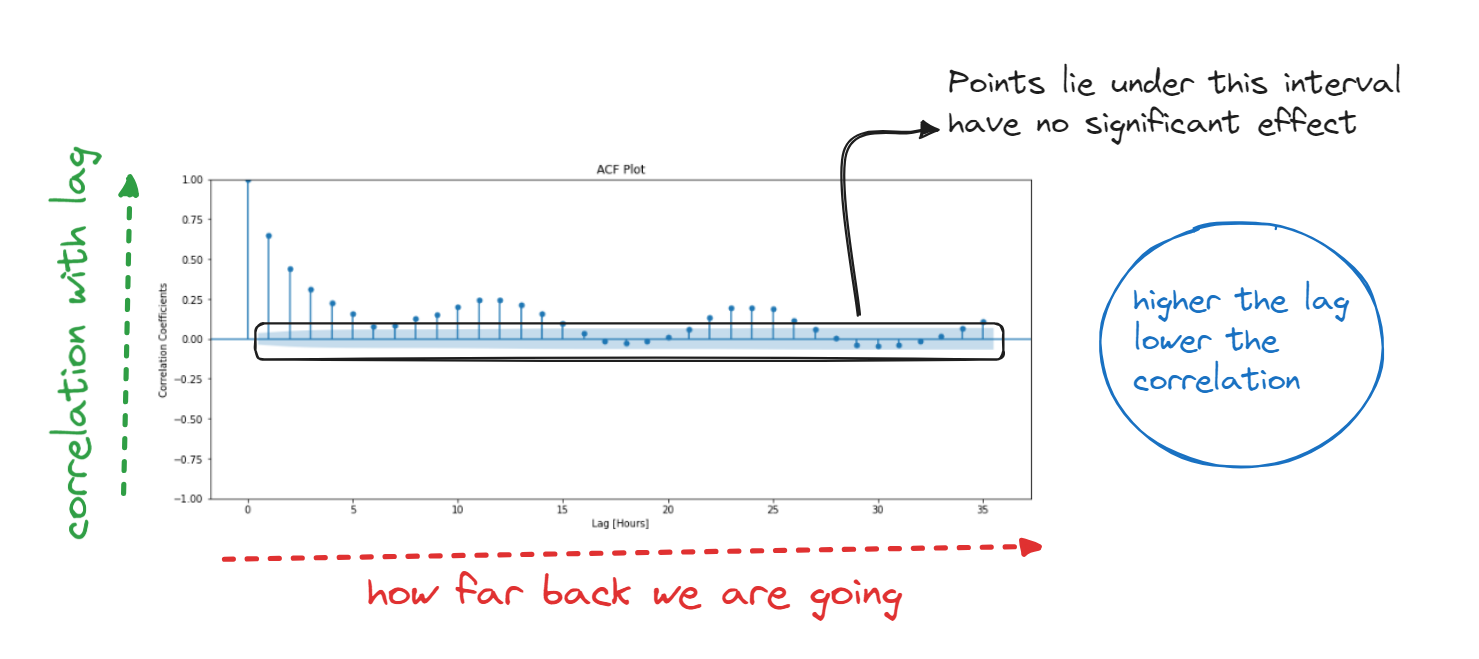

#### What we noticed ?

- Higher lags result in less correlation to a single point.

- So as per these observation you are thinking that higher lags are not useful but Wait i have another observation that seems intresting. Lets check it below....

In [20]:
# Correlation between now and 1 hour ago.
print(Nairobi_series.corr(Nairobi_series.shift(1)))

# Correlation between 1 hour ago and 2 hour ago.
print(Nairobi_series.shift(1).corr(Nairobi_series.shift(2)))

# Correlation between 2 hour ago and 3 hour ago.
print(Nairobi_series.shift(2).corr(Nairobi_series.shift(3)))

0.6506785333937846
0.650681090074551
0.6507049345141043


- So as we found that values between 1hour lags in different interval possess same correlation. This means there are some interval which are just holding this correlation. To understand which interval actually have strong prediction power we have `PACF Plot`.

### Plotting PACF

Text(0.5, 1.0, 'PACF Plot')

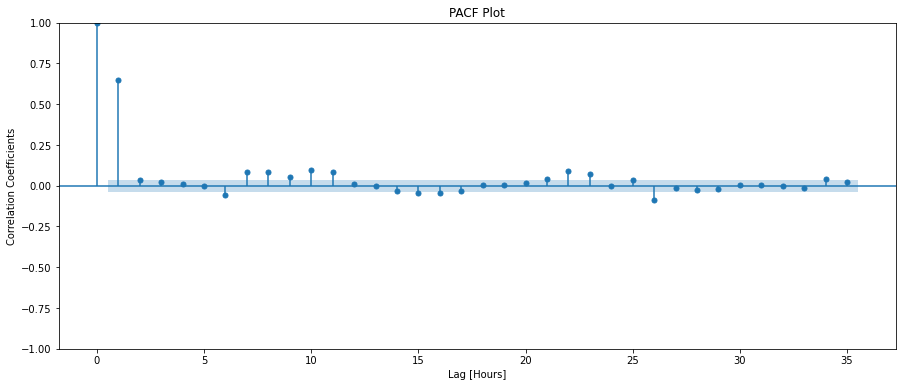

In [25]:
# Setting plot size. 
fig, ax = plt.subplots(figsize = (15,6))

# Statmodel function for pplotting acf.
plot_pacf(Nairobi_series, ax=ax)

# x-axis labeling
plt.xlabel("Lag [Hours]")

# y-axis labelling
plt.ylabel("Correlation Coefficients")


# Title of plot
plt.title("PACF Plot")

## What PACF tells ?😲

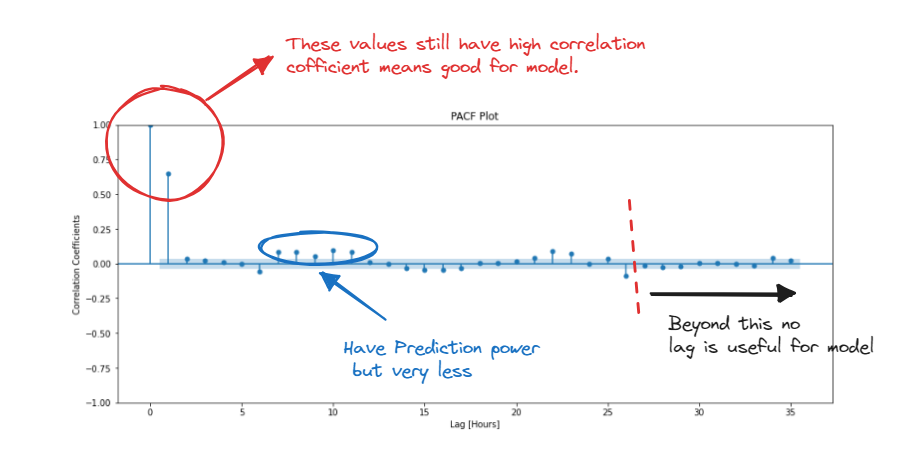

## DATA SPLIT

In [27]:
# Splitting data  90% train - 10% test 
cutoff_test = int(len(Nairobi_series)*0.95)

# Train set
y_train = Nairobi_series.iloc[:cutoff_test]

# Test set 
y_test = Nairobi_series.iloc[cutoff_test:]

## BULDING AR MODEL


### Model Eqn

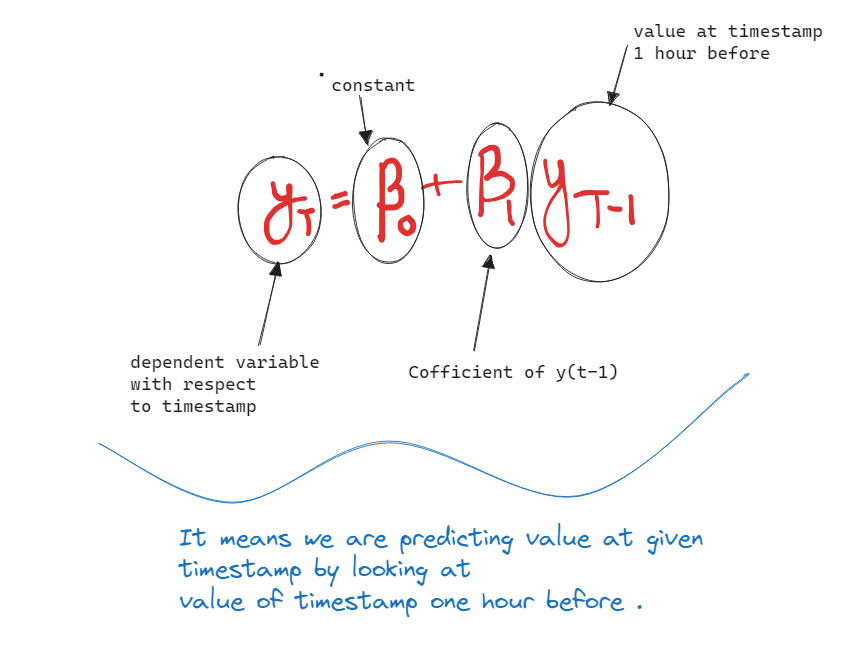

In [28]:
# Creatinf Baseling for model

y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 9.22
Baseline MAE: 3.71


In [29]:
# Model Train

AR_model = AutoReg(y_train, lags =26).fit()

### Why we are putting lag =26 ?

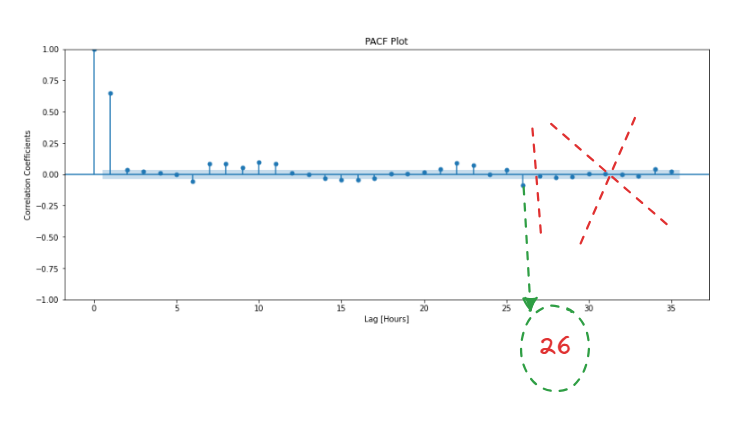

In [31]:
# Performing Predictions 

y_pred =AR_model.predict().dropna()
training_mae = mean_absolute_error(y_train.iloc[26:],y_pred)
print("Training MAE:", training_mae)

Training MAE: 2.280987165646704


##  Model Residual 

In [33]:
y_train_resid = AR_model.resid
y_train_resid.tail()

timestamp
2018-12-25 19:00:00+03:00   -0.392002
2018-12-25 20:00:00+03:00   -1.573180
2018-12-25 21:00:00+03:00   -0.735747
2018-12-25 22:00:00+03:00   -2.022221
2018-12-25 23:00:00+03:00   -0.061916
Freq: H, dtype: float64

#### Plotting Residuals

<AxesSubplot: xlabel='timestamp', ylabel='Residual Value'>

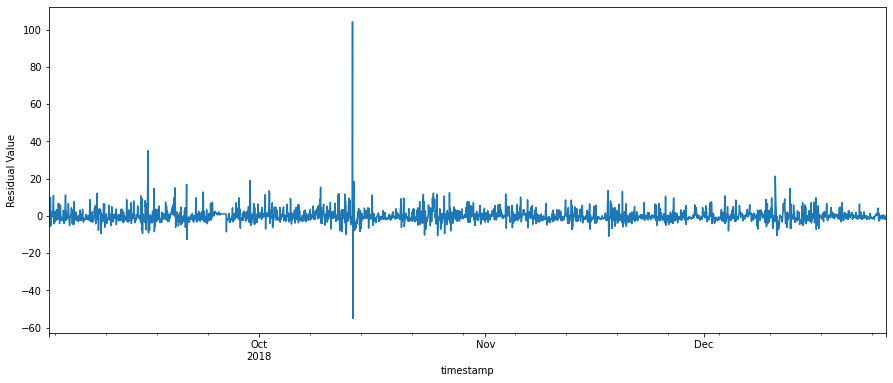

In [34]:
fig, ax = plt.subplots(figsize=(15, 6))
y_train_resid.plot(ax=ax,ylabel="Residual Value" )

- Plot signifies that residual values are centred toward zero which means residuals are normally distributed , indicates a good model...

- Higher +ve values means overestimated values ( Real Values ).

- Higher -ve values means underestimated values.

#### Histogram plotting of Residuals

Text(0.5, 1.0, 'AR(26), Distribution of Residual')

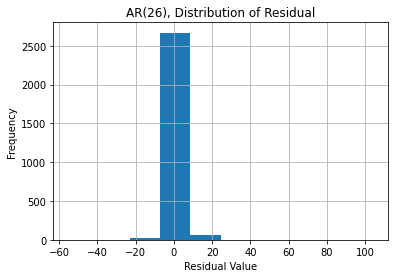

In [35]:
y_train_resid.hist()
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("AR(26), Distribution of Residual")

### RESIDUAL ACF PLOT

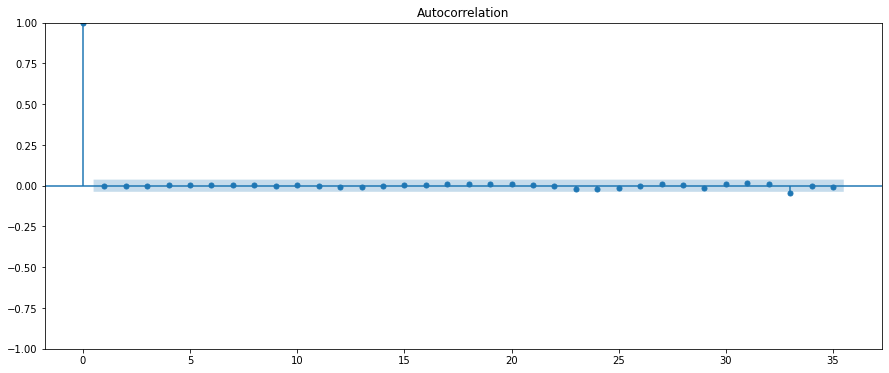

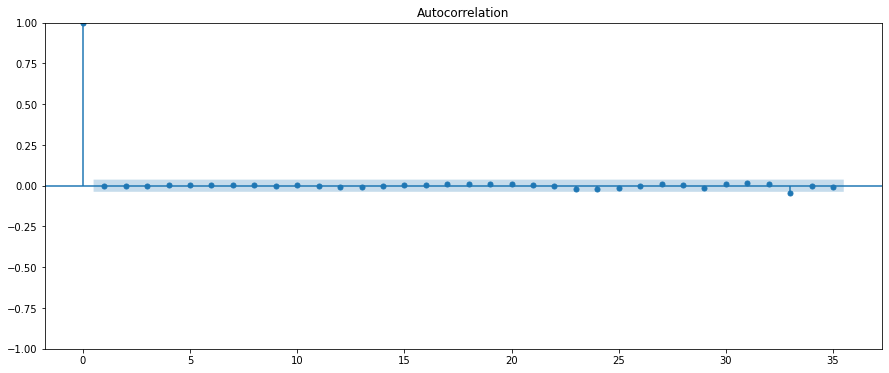

In [40]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid, ax=ax)

#### Calculating Test Mean absolute error



In [42]:
y_pred_test = AR_model.predict(y_test.index.min(),y_test.index.max())
test_mae = mean_absolute_error(y_test,y_pred_test)
print("Test MAE:", test_mae)

Test MAE: 3.01364394950391


### Plotting Result

In [44]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test, "y_pred": y_pred_test}, index=y_test.index
)

fig = px.line(df_pred_test, labels={"value": "P2"})
fig.show()

## Model Predicting Worse.. Why ??

- Let suppose our data we split in train and fit in model to cutoff length.

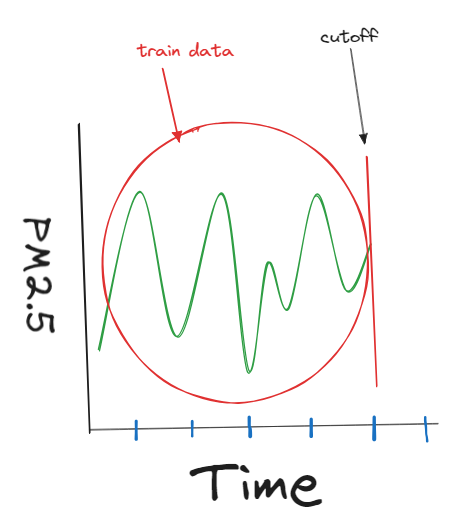 


- So now its time for model to predict , what it do i will explain you in steps.
    - As we have given it lags=26 which we also called p , for this it create a window of size 26.

    - `Our model predicts on the basis of what happens n lags before as we saw`.

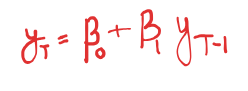

    - So it will  just took those 25 data points in window and predict its best .
            
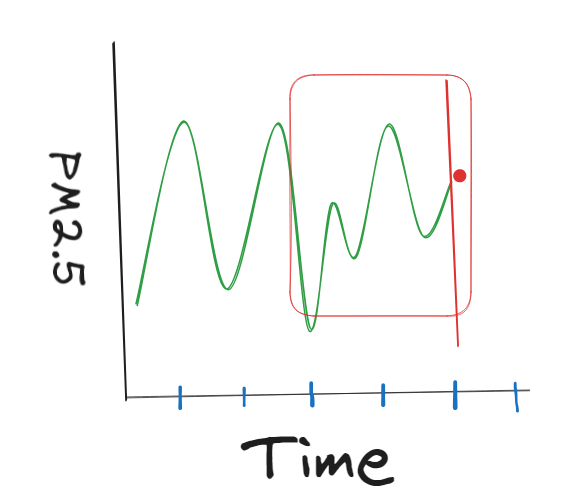

    - It do it further by moving the window forward and kepp predicting so at final the result will look like.

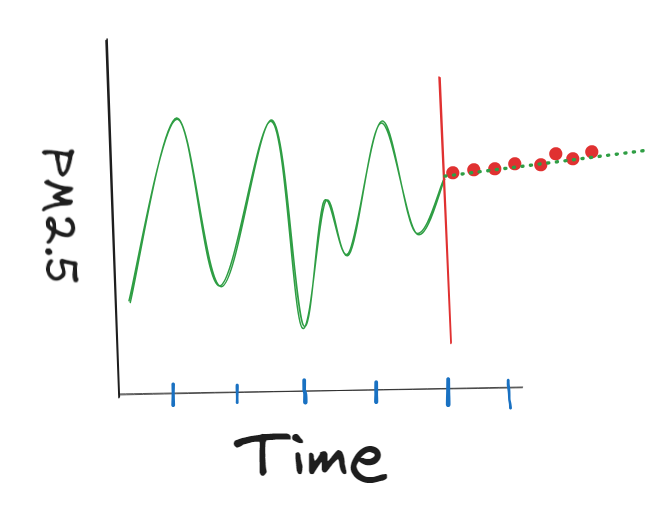



### NOTE 

> There is a time when models window have no actual point and its relies completely on prediction which makes model worse this is the reason why our model is performing too bad .

- `Don't worry, there is a solution to this traditinal test evaluation`


# New approach  (Walk-Forward Validation) 

- Lets understand what it is Walk-forward Validation


> Suppose we have a dataset represented given below in which `red` are `training points` and `yellow` are `testing points`.

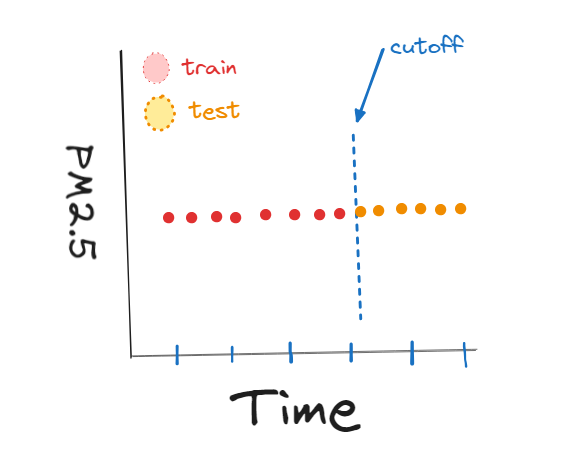


> Our model now  takes all the train points and on the basis of train it predict first point represented by `blue`.

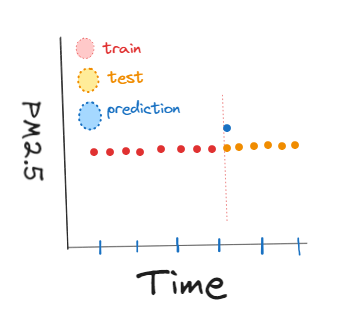

> After Predicting first point, Now it will works in a special way so predictions get strong
        
        - It include the first predicted point into train set.
        
        - By new train set it retrain model.
        
        - Again forecast value for next point and repeat this process untill a certail point reaches.

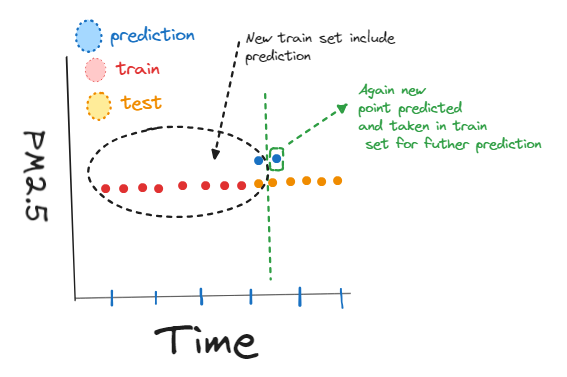

In [45]:
# Performing Forward step validation 

# Storing prediction 
y_pred_wfv = pd.Series()

# Previous data (train set)
history = y_train.copy()

# Loop run till length of test set
for i in range(len(y_test)):

    # Model fit itself for evry new prediction
    model =AutoReg(history,lags=26).fit()
    # Forecast new values based on new train set
    next_pred= model.forecast()
    # Store the result
    y_pred_wfv= y_pred_wfv.append(next_pred)
    # Add data to train set(history)
    history = history.append(y_test[next_pred.index])

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\3907105760.py:4: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\3907105760.py:17: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\3907105760.py:19: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\3907105760.py:17: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\3907105760.py:19: FutureWarning:

The series.append method is deprecated and will be removed from pandas in 

In [47]:
# Prediction length
print(len(y_pred_wfv))

test_mae = mean_absolute_error(y_test,y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

147
Test MAE (walk forward validation): 1.4


## Results

In [48]:
# Model coefficients or parameters

print(model.params)

const     2.011432
P2.L1     0.587118
P2.L2     0.019796
P2.L3     0.023615
P2.L4     0.027187
P2.L5     0.044014
P2.L6    -0.102128
P2.L7     0.029583
P2.L8     0.049867
P2.L9    -0.016897
P2.L10    0.032438
P2.L11    0.064360
P2.L12    0.005987
P2.L13    0.018375
P2.L14   -0.007636
P2.L15   -0.016075
P2.L16   -0.015953
P2.L17   -0.035444
P2.L18    0.000756
P2.L19   -0.003907
P2.L20   -0.020655
P2.L21   -0.012578
P2.L22    0.052499
P2.L23    0.074229
P2.L24   -0.023806
P2.L25    0.090577
P2.L26   -0.088323
dtype: float64


## Plotting new forecast 

In [49]:
df_pred_test = pd.DataFrame(
    {"y_test": y_test,"y_pred_wfv": y_pred_wfv}
)


fig = px.line(df_pred_test, labels = {"value":"PM2.5"})
fig.show()


- `Our technique works very well `

# WELCOMING ARMA ( AUTO REGRESSION MOVING AVERAGE ) MODELS

- Now we understand how to use ARMA models

- ARMA also works with series type data so there will no changes in our wrangle function..

In [70]:
# Library for ARMA
from statsmodels.tsa.arima.model import ARIMA
import time
import seaborn as sns

In [52]:
# List out values 

Nairobi_series.head()

timestamp
2018-09-01 03:00:00+03:00    17.541667
2018-09-01 04:00:00+03:00    15.800000
2018-09-01 05:00:00+03:00    11.420000
2018-09-01 06:00:00+03:00    11.614167
2018-09-01 07:00:00+03:00    17.665000
Freq: H, Name: P2, dtype: float64

- For ARMA we also need to understand ACF and PACF exploration. we already covered it .So we simple plot it and let move further. 

Text(0, 0.5, 'Correlation Coefficient')

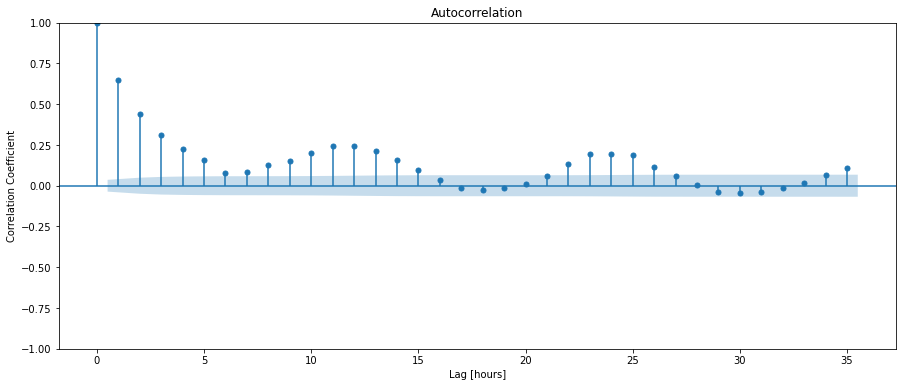

In [54]:
# Plotting ACF

fig, ax = plt.subplots(figsize = (15,6))
plot_acf(Nairobi_series, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")


Text(0, 0.5, 'Correlation Coefficient')

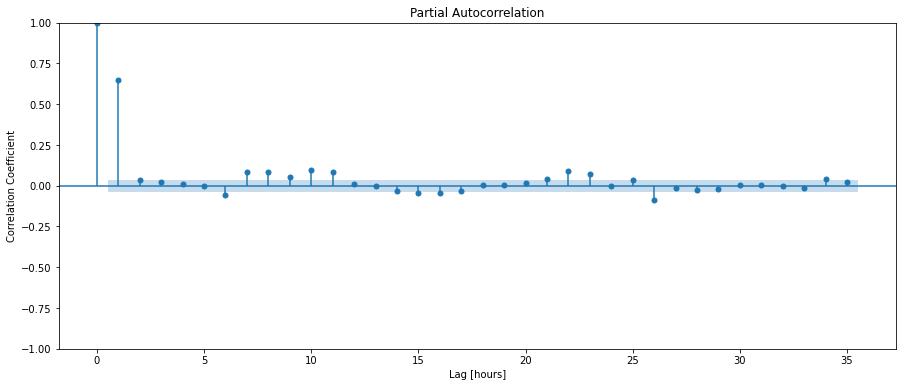

In [55]:
# Plotting PACF

fig, ax = plt.subplots(figsize = (15,6))
plot_pacf(Nairobi_series, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")

# Time To split data

- Lets understand how to split data under a timestamp range.

    - Suppose we want to split data in such a way :

        - Train contain data only from October 2018.

        - Test contain data from  1 Nov, 2018 only.

In [ ]:
# Split data for timestamp of october month only.
nairobi_train = Nairobi_series[(Nairobi_series.index >= '2018-10-01') & (Nairobi_series.index < '2018-11-01')]

# Split data for 1st November only
nairobi_test = Nairobi_series[(Nairobi_series.index.month == 11) & (Nairobi_series.index.day == 1)]

In [89]:
# Verfying train test split

print("Length of trainset is :", len(nairobi_train))
print("Length of testset is :",len(nairobi_test))

Length of trainset is : 744
Length of testset is : 24


## BUILDING ARMA MODEL

In [82]:
# Creating Baseline 

y_train_mean =nairobi_train.mean()
y_pred_baseline = [y_train_mean] * len(nairobi_train) 
mae_baseline = mean_absolute_error(nairobi_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 10.12
Baseline MAE: 4.17


### Hyperparameters 

- LETS UNDERSTAND FIRST WHY ARMA COME INTO EXISTENCE.

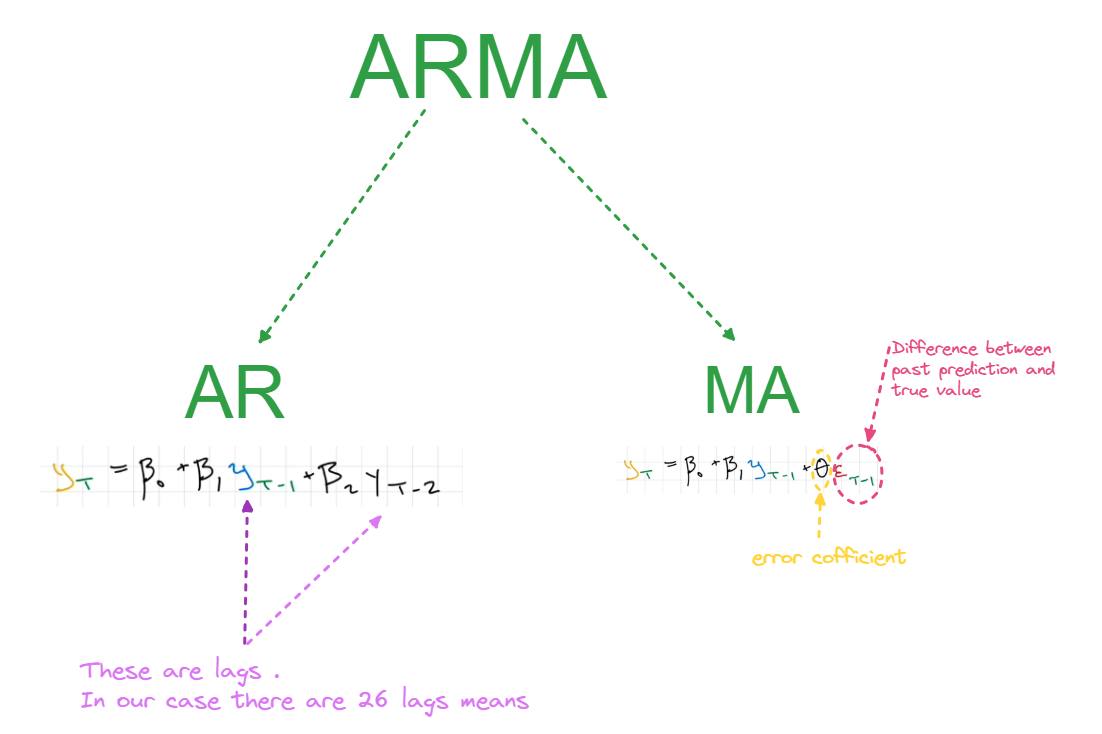


## Why this moving average ??

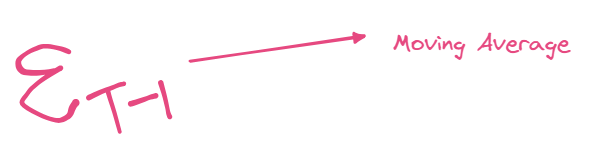

Moving average is added to model to prevent model to suffer from `Exogenous Shock`

- `Exgoneous Shock` -> One in a life time Event which ressults in outlier in data .

> Example  Here we are predicting Air Quality using PM value but what if there is a event or a situation happens result in outliers. eg-> (Building Demolition, Fireworks and Volcanic Eruptions(Just joking) etc)

- These Exhogenous shock result in high deviation of prediction . To prevent it we use Q (`Error Lag`).

- So p `Lag` and q `Error Lag` called Hyperparameters.


- To get best p value you go to your PACF plot and for q you go to ACF plot.

- Another way to find p and q is to do hyperparameter tuning.


In [64]:
p_params = range(0,25,8)
q_params = range(0,3,1)

- We are creating combination of Hyperperameter for best mae value and store it in dictionary 

In [84]:
# Create dictionary to store MAEs
mae_grid = dict()

# Outer loop: Iterate for possible values for `p`
for p in p_params:
    # Create key-value pair in dict. Key is `p`, value is empty list.
    mae_grid[p] = list()
    # Inner loop: Iterate for possible values for `q`
    for q in q_params:
        # Hyperparameters Combination  for model
        order = (p, 0, q)
        # Note start time
        start_time = time.time()
        # Train model
        model = ARIMA(nairobi_train,order=order).fit()
        # Calculate model training time
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMA {order} in {elapsed_time} seconds.")
        # Generate in-sample (training) predictions
        nairobi_pred = model.predict()
        # Calculate training MAE
        mae = mean_absolute_error(nairobi_train,nairobi_pred)
        # Append MAE to list in dictionary
        mae_grid[p].append(mae)

print()

print(mae_grid)

Trained ARIMA (0, 0, 0) in 0.12 seconds.
Trained ARIMA (0, 0, 1) in 0.07 seconds.
Trained ARIMA (0, 0, 2) in 0.11 seconds.
Trained ARIMA (8, 0, 0) in 0.28 seconds.
Trained ARIMA (8, 0, 1) in 0.98 seconds.


C:\Users\ujjwa\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (8, 0, 2) in 1.85 seconds.
Trained ARIMA (16, 0, 0) in 1.09 seconds.
Trained ARIMA (16, 0, 1) in 3.62 seconds.


C:\Users\ujjwa\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (16, 0, 2) in 5.02 seconds.
Trained ARIMA (24, 0, 0) in 4.87 seconds.
Trained ARIMA (24, 0, 1) in 6.27 seconds.


C:\Users\ujjwa\AppData\Roaming\Python\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Trained ARIMA (24, 0, 2) in 11.71 seconds.

{0: [4.171460443827197, 3.350642743347593, 3.1057222591330715], 8: [2.938448056995881, 2.9149014927619565, 2.9077216563964465], 16: [2.920108472701317, 2.9294362670750345, 2.9145209482592604], 24: [2.914390326958151, 2.91360132200785, 2.8979174187624346]}


In [85]:
# Converting dictionary to dataframe

mae_df = pd.DataFrame(mae_grid)
mae_df.round(4)

,0,8,16,24
0,4.1715,2.9384,2.9201,2.9144
1,3.3506,2.9149,2.9294,2.9136
2,3.1057,2.9077,2.9145,2.8979


Text(0.5, 1.0, 'ARMA Grid Search (Criterion: MAE)')

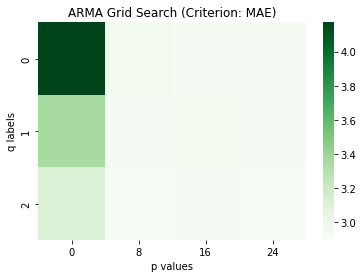

In [86]:
# Creating Heatmap for grid search
sns.heatmap(mae_df, cmap = "Greens")
plt.xlabel("p values")
plt.ylabel("q labels")
plt.title("ARMA Grid Search (Criterion: MAE)")

- Darker Values Lower Performance

### MODEL RESIDUALS 


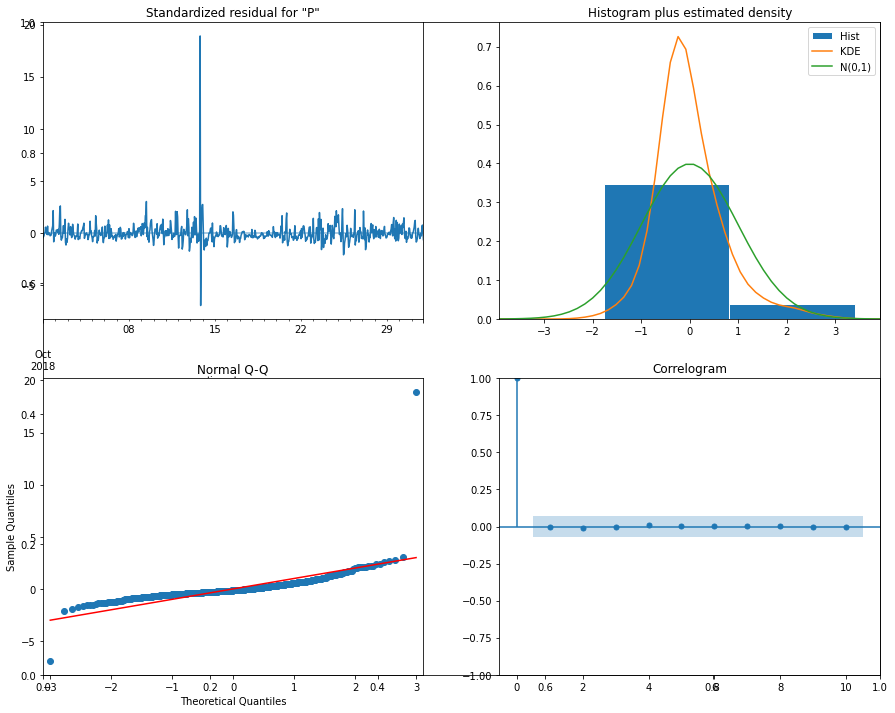

In [87]:
fig, ax = plt.subplots(figsize=(15, 12))
model.plot_diagnostics(fig =fig);

### PERFORMING WALK FORWARD VALIDATION

In [92]:
nairobi_pred_wfv = pd.Series()
history = nairobi_train.copy()
for i in range(len(nairobi_test)):
    model = ARIMA(history, order =(8,0,1)).fit()
    next_pred = model.forecast()
    nairobi_pred_wfv = nairobi_pred_wfv.append(next_pred)
    history = history.append(nairobi_test[next_pred.index])

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\2283014450.py:1: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\2283014450.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\2283014450.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\2283014450.py:6: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\ujjwa\AppData\Local\Temp\ipykernel_20428\2283014450.py:7: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a fu

In [94]:
# MEAN SQUARED ERROR
test_mae = mean_absolute_error(nairobi_test,nairobi_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 1.67


# Plotting ARMA result

In [98]:
df_predictions = pd.DataFrame({"y_test":nairobi_test, "y_pred_wfv":nairobi_pred_wfv})


In [99]:
fig = px.line(df_predictions, labels = {"value":"PM2.5"})
fig.show()

### Time series is to powerful, As i learned a lot of stuff in this journey